In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json, math
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression


sns.set_theme(style="whitegrid")

In [2]:
df = pd.read_json(
    'data/chatbot-arena-conversations.jsonl.gz',
    lines=True,
)
scores_df = pd.read_json(
    'data/chatbot-arena-gpt3-scores.jsonl.gz',
    lines=True,
)
df = df.merge(scores_df, left_index=True, right_index=True).drop('question_id_y', axis=1).rename({'question_id_x': 'question_id'}, axis=1)

In [3]:
df['prompt_length'] = df['prompt'].str.len()

In [4]:
# cleaning scores
df['score_value_1'] = df['score_value_1'].apply(lambda x: x[0][0] if isinstance(x, list) else x)
df['score_value_2'] = df['score_value_2'].apply(lambda x: x[0][0] if isinstance(x, list) else x)
df['score_value_3'] = df['score_value_3'].apply(lambda x: x[0][0] if isinstance(x, list) else x)
df['score'] = (df['score_value_1'] + df['score_value_2'] + df['score_value_3']) / 3
df['score'] = df['score'].fillna(7).astype(int)
df['score'].value_counts()

score
8    9605
7    9110
6    1486
2    1392
5    1297
9    1132
3     571
4     567
1     162
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.2)

### PCA and Clustering

In [7]:
embeddings = np.load('data/chatbot-arena-prompts-embeddings.npy')
embeddings.shape

(25322, 256)

<Axes: >

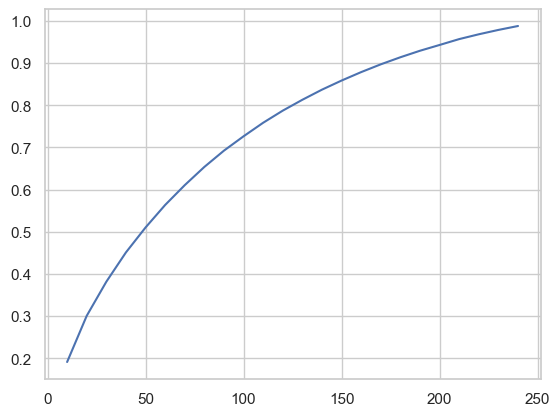

In [8]:
from sklearn.decomposition import PCA

# PCA to analyze variance explained
total_variance = []
for n in range(10, 250, 10):
    pca = PCA(n_components = n)
    pca.fit_transform(embeddings[df_train.index])
    total_variance.append(np.sum(pca.explained_variance_ratio_))

# Plot variance & components
sns.lineplot(x=range(10, 250, 10), y=total_variance)

In [9]:
pca = PCA(n_components = 200)
reduced_embeddings = pca.fit_transform(embeddings)
reduced_embeddings.shape

(25322, 200)

In [10]:
# cluster the prompts
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
#silhouette_scores = []

for n in range(2, 100, 5):
    cluster = KMeans(n_clusters=n)
    cluster.fit(reduced_embeddings[df_train.index])
    labels = cluster.predict(reduced_embeddings[df_train.index])
    inertias.append(cluster.inertia_)
    #silhouette_scores.append(silhouette_score(embeddings[adversarial_train.index], labels))

<Axes: >

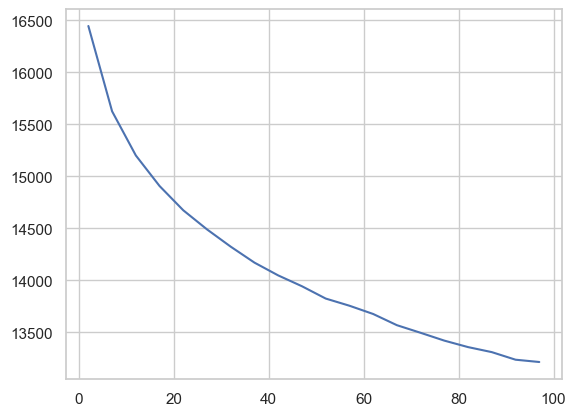

In [11]:
sns.lineplot(x=range(2, 100, 5), y=inertias)

### Exploring the Clusters

In [348]:
num_clusters = 25
cluster = KMeans(num_clusters)
cluster.fit(reduced_embeddings[df_train.index])

KMeans(n_clusters=25)

In [349]:
#cluster value counts
df_train['cluster'] = cluster.predict(reduced_embeddings[df_train.index])
df_train['cluster'].value_counts()

cluster
3     1267
0     1248
17    1187
11    1142
15    1121
14    1114
2     1028
18    1020
5     1013
4     1002
10     984
22     944
9      824
13     782
7      762
1      744
20     594
19     581
8      525
21     518
16     494
12     476
6      470
23     284
24     133
Name: count, dtype: int64

In [352]:
# looking at specific clusters
cluster_id = 24
df_train[df_train['cluster'] == cluster_id][['prompt', 'topic_modeling_1', 'topic_modeling_2', 'topic_modeling_3', 'score']].sample(10)

,prompt,topic_modeling_1,topic_modeling_2,topic_modeling_3,score
2891,What is the meaning of life?,Philosophical Inquiry,Existential Inquiry,Philosophical Inquiry,9
19256,What is the meaning of life?,Philosophical Inquiry,Philosophical Inquiry,Philosophical Inquiry,9
1924,What is life if you don’t have fun?,Philosophical Thinking,Philosophical Reflection,Philosophical Reflection,3
9997,what is the meaning of life?,Philosophical Inquiry,Philosophical Inquiry,"Philosophy, Reflection",9
15900,what is the purpose of meaning?,"Philosophy, Purpose","Philosophy, Purpose","Philosophy, Interpretation",8
13522,what is the meaning of life?,Philosophical Inquiry,Philosophical inquiry,Philosophical Inquiry,9
5172,what is the meaning of life?,Philosophical Inquiry,Philosophical Inquiry,philosophical inquiry,4
7655,"What’s the answer to life, the universe, and e...",Philosophical Riddle,Philosophical Riddle,Philosophical Question,4
9905,"Why does life exist at all? Wouldn't ""no life""...",Philosophical Inquiry,Philosophical Inquiry,Philosophical Inquiry,8
12142,What is the meaning of life for an ant?,Existential Inquiry,Philosophical Inquiry,Existential Philosophy,7


In [350]:
#scores by cluster
df_train.groupby('cluster')['score'].mean().sort_values()

cluster
1     4.629032
14    5.853680
0     6.076122
21    6.283784
20    6.341751
8     6.430476
16    6.475709
19    6.500861
12    6.628151
5     6.740375
2     6.873541
3     6.980268
11    7.000000
22    7.064619
13    7.195652
17    7.250211
4     7.266467
9     7.291262
10    7.310976
15    7.320250
6     7.338298
7     7.359580
24    7.368421
23    7.443662
18    7.775490
Name: score, dtype: float64

## Feature Engineering

In [60]:
def compute_mle_elo(df, impute=None, SCALE=400, BASE=10, INIT_RATING=1000): # add imputation
    from sklearn.linear_model import LogisticRegression
    models = pd.concat([df["model_a"], df["model_b"]]).unique()
    models = pd.Series(np.arange(len(models)), index=models)

    # duplicate battles
    df = pd.concat([df, df], ignore_index=True)
    p = len(models.index)
    n = df.shape[0]

    X = np.zeros([n, p])
    X[np.arange(n), models[df["model_a"]]] = +math.log(BASE)
    X[np.arange(n), models[df["model_b"]]] = -math.log(BASE)

    # one A win => two A win
    Y = np.zeros(n)
    Y[df["winner"] == "model_a"] = 1.0

    # one tie => one A win + one B win
    # find tie + tie (both bad) index
    tie_idx = (df["winner"] == "tie") | (df["winner"] == "tie (bothbad)")
    tie_idx[len(tie_idx)//2:] = False
    Y[tie_idx] = 1.0

    lr = LogisticRegression(fit_intercept=False)
    lr.fit(X,Y)

    elo_scores = SCALE * lr.coef_[0] + INIT_RATING

    # set anchor as llama-2-70b-chat = 1082
    if "llama-2-70b-chat" in models.index:
        elo_scores += 1082 - elo_scores[models["llama-2-70b-chat"]]
    return pd.Series(elo_scores, index = models.index).sort_values(ascending=False)

In [61]:
#calculating elo
elo = compute_mle_elo(df_train).astype(int)
elo

gpt-4                      1231
claude-v1                  1189
claude-instant-v1          1161
gpt-3.5-turbo              1125
guanaco-33b                1081
palm-2                     1074
vicuna-13b                 1054
wizardlm-13b               1040
vicuna-7b                  1017
koala-13b                  1008
mpt-7b-chat                 954
gpt4all-13b-snoozy          951
RWKV-4-Raven-14B            944
oasst-pythia-12b            920
alpaca-13b                  919
fastchat-t5-3b              905
chatglm-6b                  896
stablelm-tuned-alpha-7b     863
dolly-v2-12b                844
llama-13b                   815
dtype: int64

In [353]:
# elo for specific cluster
compute_mle_elo(df_train[df_train['cluster']==24]).astype(int)

palm-2                     1332
claude-instant-v1          1248
mpt-7b-chat                1143
koala-13b                  1099
gpt-3.5-turbo              1079
gpt-4                      1069
claude-v1                  1058
dolly-v2-12b               1048
vicuna-13b                 1039
stablelm-tuned-alpha-7b    1008
oasst-pythia-12b            982
vicuna-7b                   926
fastchat-t5-3b              917
alpaca-13b                  915
chatglm-6b                  910
RWKV-4-Raven-14B            904
llama-13b                   840
gpt4all-13b-snoozy          739
wizardlm-13b                735
dtype: int64

In [271]:
# elo for high score
compute_mle_elo(df_train[df_train['score']==9]).astype(int)

gpt-4                      1321
claude-instant-v1          1286
claude-v1                  1166
guanaco-33b                1145
gpt-3.5-turbo              1130
vicuna-13b                 1087
vicuna-7b                  1048
palm-2                     1035
koala-13b                  1014
mpt-7b-chat                 996
RWKV-4-Raven-14B            944
chatglm-6b                  935
stablelm-tuned-alpha-7b     921
oasst-pythia-12b            917
alpaca-13b                  912
wizardlm-13b                868
fastchat-t5-3b              860
gpt4all-13b-snoozy          860
dolly-v2-12b                810
llama-13b                   733
dtype: int64

In [92]:
# elo for low score
compute_mle_elo(df_train[df_train['score']==3]).astype(int)

claude-instant-v1          1320
claude-v1                  1148
gpt-4                      1145
gpt-3.5-turbo              1077
vicuna-13b                 1067
palm-2                     1045
vicuna-7b                  1034
koala-13b                  1019
guanaco-33b                1013
wizardlm-13b                995
mpt-7b-chat                 966
RWKV-4-Raven-14B            963
chatglm-6b                  953
alpaca-13b                  948
oasst-pythia-12b            942
fastchat-t5-3b              908
llama-13b                   907
dolly-v2-12b                888
gpt4all-13b-snoozy          838
stablelm-tuned-alpha-7b     814
dtype: int64

In [97]:
#calculating basline accuracy
baseline_y = (df['model_a'].map(elo) > df['model_b'].map(elo)).map({True: 'model_a', False: 'model_b'})
baseline_accuracy = sum(baseline_y == df['winner']) / len(df)
baseline_accuracy

0.5299344443566859

In [116]:
def compute_percent_adversarial(df):
    # Calculate baseline winners based on high ELO
    baseline_df = (df['model_a'].map(elo) > df['model_b'].map(elo)).map({True: 'model_a', False: 'model_b'})
    
    # Identify matches where the winner was not the baseline prediction and wasn't a tie
    adversarial_df = df[(df['winner'] != baseline_df) & ~(df['winner'].str.contains('tie'))]
    
    # Calculate and return the percentage of adversarial wins by cluster
    return adversarial_df['cluster'].value_counts().sort_index() / df['cluster'].value_counts().sort_index()

In [111]:
def compute_percent_tied(df):
    # Filter rows where the winner is tie
    tied_df = df[df['winner'].str.contains('tie')]
    
    # Return the proportion of ties by cluster
    return tied_df['cluster'].value_counts().sort_index() / df['cluster'].value_counts().sort_index()

In [172]:
def compute_percent_tied_bothbad(df):
    # Filter rows where the winner description contains 'bothbad' indicating a bad tie
    bad_tie_df = df[df['winner'].str.contains('bothbad')]
    
    # Return the proportion of 'bothbad' ties by cluster
    return bad_tie_df['cluster'].value_counts().sort_index() / df['cluster'].value_counts().sort_index()

In [102]:
def compute_average_lengths(df):
    # Calculate the length of the second message in each conversation for both models
    df['response_a_length'] = df['conversation_a'].str[1].str['content'].str.len()
    df['response_b_length'] = df['conversation_b'].str[1].str['content'].str.len()
    
    # Compute the sum of response lengths for each model and normalize by the number of occurrences of each model
    average_lengths = (
        (df.groupby('model_a')['response_a_length'].sum() + df.groupby('model_b')['response_b_length'].sum())
        / (df.groupby('model_a').size() + df.groupby('model_b').size())
    ).rename_axis('model')
    
    return average_lengths

In [103]:
def compute_mean_scores(df):
    return df.groupby(all_labels)['score'].mean()

In [104]:
def compute_head_to_head(df):
    # Count all matchups between each pair of models, regardless of who is listed as model_a or model_b
    all_battles = (
        pd.pivot_table(df, index='model_a', columns='model_b', aggfunc='size', fill_value=0) +
        pd.pivot_table(df, index='model_b', columns='model_a', aggfunc='size', fill_value=0)
    )

    # Count wins where each model is listed as model_a or model_b
    model_a_wins = pd.pivot_table(df[df['winner'] == 'model_a'], index='model_a', columns='model_b', aggfunc='size', fill_value=0).sort_index()
    model_b_wins = pd.pivot_table(df[df['winner'] == 'model_b'], index='model_b', columns='model_a', aggfunc='size', fill_value=0).sort_index()

    # Calculate win ratios for each model pairing and fill non-existing battles with 0
    return ((model_a_wins + model_b_wins) / all_battles).fillna(0)

In [114]:
def create_features(input, all_data, n_clusters):
    input['prompt_length'] = input['prompt'].str.len()
    elo = compute_mle_elo(all_data).astype(int)
    input['model_a_elo'] = input['model_a'].map(elo)
    input['model_b_elo'] = input['model_b'].map(elo)
    score_elo = [None]
    for i in range(9):
        score_elo.append(compute_mle_elo(all_data[all_data['score'] == i+1]))
    input['model_a_score_elo'] = input.apply(lambda x: score_elo[x['score']][x['model_a']], axis=1)
    input['model_b_score_elo'] = input.apply(lambda x: score_elo[x['score']][x['model_b']], axis=1)
    lengths = compute_average_lengths(all_data)
    input['model_a_length'] = input['model_a'].map(lengths)
    input['model_b_length'] = input['model_b'].map(lengths)
    head_to_head = compute_head_to_head(all_data)
    input['model_a_win_rate'] = input.apply(lambda x: head_to_head.loc[x['model_a']][x['model_b']], axis=1)
    input['model_b_win_rate'] = input.apply(lambda x: head_to_head.loc[x['model_b']][x['model_a']], axis=1)
    percent_adversarial = compute_percent_adversarial(all_data)
    input['cluster'] = cluster.predict(reduced_embeddings[input.index])
    all_labels = cluster.predict(reduced_embeddings[all_data.index])
    input['percent_adversarial'] = input['cluster'].map(percent_adversarial)
    percent_tied = compute_percent_tied(all_data)
    input['percent_tied'] = input['cluster'].map(percent_tied)
    percent_tied_bothbad = compute_percent_tied_bothbad(all_data)
    input['percent_tied_bothbad'] = input['cluster'].map(percent_tied_bothbad)
    cluster_elo = []
    cluster_model_count = []
    for i in range(n_clusters):
        cluster_elo.append(compute_mle_elo(all_data[all_labels == i]))
        cluster_model_count.append(all_data[all_labels == i].groupby('model_a').size() + all_data[all_labels == i].groupby('model_b').size())
    def compute_cluster_elo(x, model_a):
        m = x['model_a'] if model_a else x['model_b']
        c = x['cluster']
        return cluster_elo[c][m] if (m in cluster_model_count[c] and cluster_model_count[c][m] >= 10) else elo[m]
    input['model_a_cluster_elo'] = input.apply(lambda x: compute_cluster_elo(x, True), axis=1)
    input['model_b_cluster_elo'] = input.apply(lambda x: compute_cluster_elo(x, False), axis=1)
    #cluster_head_to_head = []
    #for i in range(n_clusters):
    #    cluster_head_to_head.append(compute_head_to_head(all_data[all_labels == i]))
    #input['model_a_cluster_win_rate'] = input.apply(lambda x: cluster_head_to_head[x['cluster']].loc[x['model_a']][x['model_b']], axis=1)
    #input['model_b_cluster_win_rate'] = input.apply(lambda x: cluster_head_to_head[x['cluster']].loc[x['model_b']][x['model_a']], axis=1)
    #score_head_to_head = []
    #for i in range(10):
    #    score_head_to_head.append(compute_head_to_head(all_data[all_data['score'] == i]))
    #input['model_a_score_win_rate'] = input.apply(lambda x: score_head_to_head[x['score']].loc[x['model_a']][x['model_b']], axis=1)
    #input['model_b_score_win_rate'] = input.apply(lambda x: score_head_to_head[x['score']].loc[x['model_a']][x['model_b']], axis=1)
    return input

In [231]:
train = create_features(df_train, df_train, num_clusters)

In [232]:
val = create_features(df_val, df_train, num_clusters)

In [149]:
from sklearn.preprocessing import StandardScaler

In [119]:
def process(input):
    #features = ['model_a_elo', 'model_b_elo', 'model_a_length', 'model_b_length', 'model_a_win_rate', 'model_b_win_rate', 'percent_adversarial', 'model_a_cluster_win_rate', 'model_b_cluster_win_rate', 'winner']
    features = ['prompt_length', 'score', 'model_a_elo', 'model_b_elo', 'model_a_cluster_elo', 'model_b_cluster_elo', 'model_a_score_elo', 'model_b_score_elo', 'percent_adversarial', 'percent_tied', 'percent_tied_bothbad', 'winner', 'cluster', 'model_a_length', 'model_b_length']
    input = input[features]
    #input['a_elo * adversarial'] = input['model_a_cluster_elo'] * input['percent_adversarial']
    #input['b_elo * adversarial'] = input['model_b_cluster_elo'] * input['percent_adversarial']
    #input['a_elo * tie'] = input['model_a_cluster_elo'] * input['percent_tied']
    #input['b_elo * tie'] = input['model_b_cluster_elo'] * input['percent_tied']
    #input['a_elo * bad tie'] = input['model_a_cluster_elo'] * input['percent_tied_bothbad']
    #input['b_elo * bad tie'] = input['model_b_cluster_elo'] * input['percent_tied_bothbad']
    ties = input[input['winner'].str.contains('tie')]
    no_ties = input[~input['winner'].str.contains('tie')]
    y = no_ties['winner'].map({'model_a': 0, 'model_b': 1})
    X = no_ties.drop('winner', axis=1)
    tie_labels = ties['winner'].map({'tie': 2, 'tie (bothbad)': 3})
    ties = ties.drop('winner', axis=1)
    return X, y, ties, tie_labels

In [166]:
def process_with_ties(input):
    #features = ['model_a_elo', 'model_b_elo', 'model_a_length', 'model_b_length', 'model_a_win_rate', 'model_b_win_rate', 'percent_adversarial', 'model_a_cluster_win_rate', 'model_b_cluster_win_rate', 'winner']
    features = ['prompt_length', 'score', 'model_a_elo', 'model_b_elo', 'model_a_cluster_elo', 'model_b_cluster_elo', 'model_a_score_elo', 'model_b_score_elo', 'winner', 'cluster', 'model_a_length', 'model_b_length']
    input = input[features]
    #input['a_elo * adversarial'] = input['model_a_cluster_elo'] * input['percent_adversarial']
    #input['b_elo * adversarial'] = input['model_b_cluster_elo'] * input['percent_adversarial']
    #input['a_elo * tie'] = input['model_a_cluster_elo'] * input['percent_tied']
    #input['b_elo * tie'] = input['model_b_cluster_elo'] * input['percent_tied']
    #input['a_elo * bad tie'] = input['model_a_cluster_elo'] * input['percent_tied_bothbad']
    #input['b_elo * bad tie'] = input['model_b_cluster_elo'] * input['percent_tied_bothbad']
    y = input['winner'].map({'model_a': 0, 'model_b': 1, 'tie': 2, 'tie (bothbad)': 3})
    X = input.drop('winner', axis=1)
    return X, y

In [220]:
X_train, y_train, ties_train, tie_train_labels = process(train)
X_val, y_val, ties_val, tie_val_labels = process(val)

In [171]:
X_train.corr()

,prompt_length,score,model_a_elo,model_b_elo,model_a_cluster_elo,model_b_cluster_elo,model_a_score_elo,model_b_score_elo,percent_adversarial,percent_tied,percent_tied_bothbad,cluster,model_a_length,model_b_length
prompt_length,1.000000,0.199916,0.019338,0.039382,0.021445,0.035230,0.019195,0.040630,-0.051985,0.007563,NaN,0.072969,0.023654,0.036657
score,0.199916,1.000000,0.027281,0.037290,0.029423,0.028901,0.032788,0.033315,-0.060873,-0.098681,NaN,0.061399,0.018894,0.023130
model_a_elo,0.019338,0.027281,1.000000,-0.083030,0.935701,-0.090270,0.978916,-0.079107,-0.052224,0.048691,NaN,0.040538,0.691870,-0.042696
model_b_elo,0.039382,0.037290,-0.083030,1.000000,-0.085823,0.935630,-0.081176,0.979568,-0.039307,0.022558,NaN,0.017458,-0.034955,0.690547
model_a_cluster_elo,0.021445,0.029423,0.935701,-0.085823,1.000000,-0.098179,0.920343,-0.082058,-0.040187,0.032321,NaN,0.029762,0.649906,-0.047753
model_b_cluster_elo,0.035230,0.028901,-0.090270,0.935630,-0.098179,1.000000,-0.089697,0.921594,-0.031731,0.012478,NaN,0.002395,-0.040724,0.646162
model_a_score_elo,0.019195,0.032788,0.978916,-0.081176,0.920343,-0.089697,1.000000,-0.080071,-0.054278,0.047867,NaN,0.040525,0.677174,-0.041684
model_b_score_elo,0.040630,0.033315,-0.079107,0.979568,-0.082058,0.921594,-0.080071,1.000000,-0.037372,0.023064,NaN,0.017043,-0.032827,0.676478
percent_adversarial,-0.051985,-0.060873,-0.052224,-0.039307,-0.040187,-0.031731,-0.054278,-0.037372,1.000000,-0.604498,NaN,-0.195115,-0.033161,-0.036518
percent_tied,0.007563,-0.098681,0.048691,0.022558,0.032321,0.012478,0.047867,0.023064,-0.604498,1.000000,NaN,0.471845,0.035351,0.015157


In [233]:
X_train_with_ties, y_train_with_ties = process_with_ties(train)
X_val_with_ties, y_val_with_ties = process_with_ties(val)

In [123]:
def create_ensemble_features(X):
    # elo, cluster elo, score elo
    ensemble_df = pd.DataFrame(index=X.index)
    ensemble_df['elo_difference'] = X['model_a_elo'] - X['model_b_elo']
    ensemble_df['cluster_elo_difference'] = X['model_a_cluster_elo'] - X['model_b_cluster_elo']
    ensemble_df['score_elo_difference'] = X['model_a_score_elo'] - X['model_b_score_elo']
    #ensemble_df['length_difference'] = X['model_a_length'] - X['model_b_length']
    return ensemble_df

In [156]:
def build_cluster_models(X, y):
    scaler = StandardScaler()
    cluster_models = []
    for n in range(num_clusters):
        #X_cluster = create_ensemble_features(X[X['cluster'] == n].drop(['cluster', 'percent_adversarial', 'percent_tied', 'percent_tied_bothbad'], axis=1))
        #X_cluster = X[X['cluster'] == n].drop(['cluster', 'percent_adversarial', 'percent_tied', 'percent_tied_bothbad'], axis=1)
        X_cluster = scaler.fit_transform(X[X['cluster'] == n].drop('cluster', axis=1))
        #X_cluster = create_ensemble_features(X[X['cluster'] == n].drop('cluster', axis=1))
        y_cluster = y[X['cluster'] == n]
        model = LogisticRegression(max_iter=5000)
        cluster_models.append(model.fit(X_cluster, y_cluster))
    return cluster_models

In [182]:
def test_cluster_models(X, y, cluster_models):
    scaler = StandardScaler()
    accuracies = []
    confusion_matrices = []
    for n in range(num_clusters):
        #X_cluster = create_ensemble_features(X[X['cluster'] == n].drop(['cluster', 'percent_adversarial', 'percent_tied', 'percent_tied_bothbad'], axis=1))
        #X_cluster = X[X['cluster'] == n].drop(['cluster', 'percent_adversarial', 'percent_tied', 'percent_tied_bothbad'], axis=1)
        X_cluster = scaler.fit_transform(X[X['cluster'] == n].drop('cluster', axis=1))
        #X_cluster = create_ensemble_features(X[X['cluster'] == n].drop('cluster', axis=1))
        y_cluster = y[X['cluster'] == n]
        model = cluster_models[n]
        y_pred_cluster = model.predict(X_cluster)
        accuracies.append(accuracy_score(y_cluster, y_pred_cluster))
        confusion_matrices.append(confusion_matrix(y_cluster, y_pred_cluster))
    return accuracies, confusion_matrices

### Modeling

In [234]:
# Build models for each cluster with training data that includes ties
cluster_models_with_ties = build_cluster_models(X_train_with_ties, y_train_with_ties)

# Test the models on the training set and get accuracy and confusion matrix
train_accuracy, train_confusion = test_cluster_models(X_train_with_ties, y_train_with_ties, cluster_models_with_ties)

# Test the models on the validation set and get accuracy and confusion matrix
val_accuracy, val_confusion = test_cluster_models(X_val_with_ties, y_val_with_ties, cluster_models_with_ties)

# Calculate and print weighted training accuracy by cluster size
print("Training accuracy:", np.dot(train_accuracy, X_train_with_ties.groupby('cluster').size()) / len(X_train_with_ties))

# Calculate and print weighted validation accuracy by cluster size
print("Validation accuracy:", np.dot(val_accuracy, X_val_with_ties.groupby('cluster').size()) / len(X_val_with_ties))

Training accuracy: 0.5656316335094042
Validation accuracy: 0.5423494570582429


In [206]:
# Aggregate all individual confusion matrices to get the overall training confusion matrix
train_confusion_matrix = sum(train_confusion)

# Compute true positives, false negatives, and false positives from the confusion matrix
tp = np.diag(train_confusion_matrix)  # True Positives: diagonal elements
fn = np.sum(train_confusion_matrix, axis=1) - tp  # False Negatives: sum over rows minus TP
fp = np.sum(train_confusion_matrix, axis=0) - tp  # False Positives: sum over columns minus TP

# Calculate and print precision for each class and total precision across all classes
print("Training precision:", tp / (tp + fp))
print("Total precision:", np.sum(tp) / (np.sum(tp) + np.sum(fp)))

# Calculate and print recall for each class and total recall across all classes
print("Training recall:", tp / (tp + fn))
print("Total recall:", np.sum(tp) / (np.sum(tp) + np.sum(fn)))


Training precision: [0.57347554 0.57454955 0.42857143 0.49527807]
Total precision: 0.565236708298366
Training recall: [0.73481502 0.71657303 0.03633917 0.25764192]
Total recall: 0.565236708298366


In [208]:
train_confusion_matrix

array([[5323, 1437,   47,  437],
       [1543, 5102,   47,  428],
       [1030, 1021,   81,   97],
       [1386, 1320,   14,  944]])

In [207]:
# Aggregate all individual confusion matrices to create the overall validation confusion matrix
val_confusion_matrix = sum(val_confusion)

# Calculate true positives, false negatives, and false positives from the validation confusion matrix
tp = np.diag(val_confusion_matrix)  # True Positives: diagonal elements
fn = np.sum(val_confusion_matrix, axis=1) - tp  # False Negatives: sum over rows minus TP
fp = np.sum(val_confusion_matrix, axis=0) - tp  # False Positives: sum over columns minus TP

# Calculate and display precision for each class and the overall precision for the validation set
print("Validation precision:", tp / (tp + fp))
print("Total precision:", np.sum(tp) / (np.sum(tp) + np.sum(fp)))

# Calculate and display recall for each class and the overall recall for the validation set
print("Validation recall:", tp / (tp + fn))
print("Total recall:", np.sum(tp) / (np.sum(tp) + np.sum(fn)))

Validation precision: [0.55250545 0.55241935 0.38095238 0.47580645]
Total precision: 0.5435340572556762
Validation recall: [0.7143662  0.70336566 0.02857143 0.24155578]
Total recall: 0.5435340572556762


In [209]:
train_confusion_matrix

array([[5323, 1437,   47,  437],
       [1543, 5102,   47,  428],
       [1030, 1021,   81,   97],
       [1386, 1320,   14,  944]])

In [169]:
pd.DataFrame(data=[cluster_models_with_ties[n].coef_[0,:] for n in range(num_clusters)], columns=X_train_with_ties.drop('cluster', axis=1).columns)

,prompt_length,score,model_a_elo,model_b_elo,model_a_cluster_elo,model_b_cluster_elo,model_a_score_elo,model_b_score_elo,model_a_length,model_b_length
0,0.232854,-0.002275,-0.147165,0.291856,0.378397,-0.481401,0.535747,-0.467966,-0.200358,-0.020707
1,0.194185,-0.001728,-0.307071,0.718968,0.434354,-0.557388,0.579834,-0.930799,0.005355,0.086785
2,-0.207856,0.062449,-0.919211,0.000104,0.827481,-0.228710,0.919725,-0.230369,-0.247999,-0.288369
3,0.076493,-0.041402,-0.846358,0.504165,0.994705,-0.500112,0.738874,-0.698228,-0.199407,0.083322
4,0.011610,-0.013097,-0.311967,0.366972,0.483548,-0.663786,0.466151,-0.156435,-0.013131,-0.062203
5,0.069174,-0.102056,-0.671761,0.555373,0.388079,-0.595196,0.794140,-0.340863,-0.050730,-0.156807
6,-0.045874,-0.118470,-0.556260,0.069536,0.818014,-0.290952,0.471916,-0.192408,-0.183240,-0.045419
7,0.041423,-0.018226,0.352422,0.270122,0.385443,-0.828169,-0.008684,-0.038823,-0.097245,-0.035937
8,0.027658,0.014956,-0.560019,0.595100,0.458065,-0.624995,0.797637,-0.344720,-0.095410,-0.060309
9,0.015870,-0.087166,-0.121874,0.079394,0.528057,-0.493587,0.079961,0.007153,0.087001,-0.018558


In [170]:
pd.DataFrame(data=[cluster_models_with_ties[n].coef_[3,:] for n in range(num_clusters)], columns=X_train_with_ties.drop('cluster', axis=1).columns)

,prompt_length,score,model_a_elo,model_b_elo,model_a_cluster_elo,model_b_cluster_elo,model_a_score_elo,model_b_score_elo,model_a_length,model_b_length
0,0.035398,0.115182,-0.670312,0.036566,-0.280324,-0.357268,0.233876,0.188624,0.299390,-0.089754
1,-0.099397,0.057894,0.167280,-0.133158,0.070606,-0.108113,-0.621804,-0.061853,0.056029,0.076100
2,0.172738,0.195230,0.207251,0.014059,-0.169074,-0.581498,-0.491115,0.200751,0.109710,0.133361
3,0.126906,0.051281,-0.202825,-0.324829,-0.225575,0.549606,0.135893,-0.199350,-0.020663,-0.243343
4,-0.081237,0.133229,-0.197941,-0.262101,-0.041936,0.052592,-0.077601,-0.153516,0.026121,0.225122
5,0.093138,0.413897,0.592792,0.041498,-0.376644,0.155666,-0.472081,-0.156923,-0.021911,-0.112565
6,0.174821,0.211835,-0.085722,0.229602,-0.580287,-0.244915,0.137876,-0.425709,0.138477,0.032144
7,0.021207,0.082079,-0.289901,-0.269689,-0.085053,-0.217939,-0.132513,0.005054,0.154468,0.167698
8,0.182411,0.028000,0.141723,0.319070,0.056287,-0.286752,-0.759284,-0.462900,0.277680,0.258977
9,0.271802,0.232313,-0.637754,0.023513,-0.092262,-0.251846,0.376743,-0.340839,-0.147818,0.127862


In [596]:
cluster_models = build_cluster_models(X_train, y_train)
print("Training accuracy:", np.dot(test_cluster_models(X_train, y_train, cluster_models), X_train.groupby('cluster').size()) / len(X_train))
print("Validation accuracy:", np.dot(test_cluster_models(X_val, y_val, cluster_models), X_val.groupby('cluster').size()) / len(X_val))

Training accuracy: 0.7662464985994398
Validation accuracy: 0.7494462901439646


In [128]:
print(accuracy_score(y_train_with_ties, X_train_with_ties['model_a_cluster_elo'] < X_train_with_ties['model_b_cluster_elo']))

0.5415411956360764


In [130]:
print(accuracy_score(y_train_with_ties, X_train_with_ties['model_a_score_elo'] < X_train_with_ties['model_b_score_elo']))

0.5330996692501357


In [131]:
print(accuracy_score(y_val_with_ties, X_val_with_ties['model_a_score_elo'] < X_val_with_ties['model_b_score_elo']))

0.5247778874629813


In [129]:
print(accuracy_score(y_val_with_ties, X_val_with_ties['model_a_cluster_elo'] < X_val_with_ties['model_b_cluster_elo']))

0.528923988153998


In [597]:
probabilities = np.concatenate([cluster_models[n].predict_proba(X_train[X_train['cluster']==n].drop('cluster', axis=1))[:,0] for n in range(num_clusters)])

In [598]:
tie_probabilities = np.concatenate([cluster_models[n].predict_proba(ties_train[ties_train['cluster']==n].drop('cluster', axis=1))[:,0] for n in range(num_clusters)])

In [630]:
untied_labels = np.concatenate([y_train[X_train['cluster']==n] for n in range(num_clusters)])

In [632]:
pd.Series(untied_labels).value_counts()

0    7195
1    7085
Name: count, dtype: int64

<Axes: ylabel='Density'>

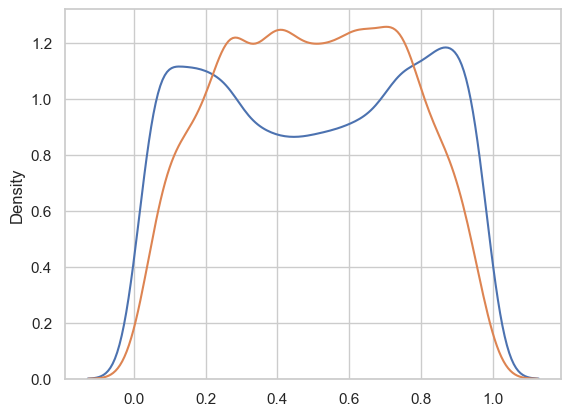

In [599]:
#plotting KDE plots
sns.kdeplot(probabilities)
sns.kdeplot(tie_probabilities)

In [669]:
cluster_id = 4
untied_probabilities = cluster_models[cluster_id].predict_proba(X_train[X_train['cluster']==cluster_id].drop('cluster', axis=1))[:,0]
tied_probabilities = cluster_models[cluster_id].predict_proba(ties_train[ties_train['cluster']==cluster_id].drop('cluster', axis=1))[:,0]

<Axes: ylabel='Density'>

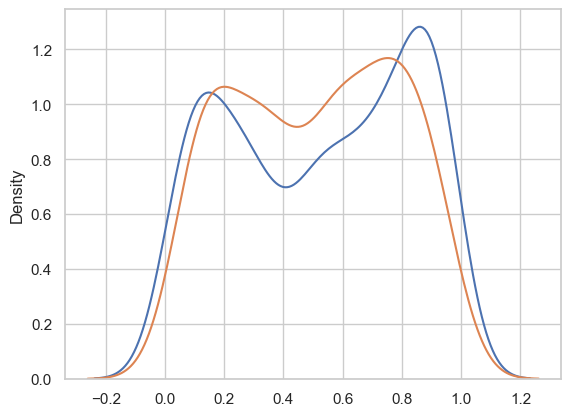

In [670]:
#plotting KDE plots
sns.kdeplot(untied_probabilities)
sns.kdeplot(tied_probabilities)

In [619]:
cluster_id = 9
cluster_probs = cluster_models[cluster_id].predict_proba(X_train_with_ties[X_train_with_ties['cluster']==cluster_id].drop('cluster', axis=1))[:,0]
cluster_labels = y_train_with_ties[X_train_with_ties['cluster']==cluster_id]

In [640]:
def threshold(x, lower, upper):
    if x <= lower:
        return 1
    if x >= upper:
        return 0
    return 2

In [645]:
all_probabilities = np.concatenate([cluster_models[n].predict_proba(X_train_with_ties[X_train_with_ties['cluster']==n].drop('cluster', axis=1))[:,0] for n in range(num_clusters)])
all_labels = np.concatenate([y_train_with_ties[X_train_with_ties['cluster']==n] for n in range(num_clusters)])

In [646]:
simplified_labels = pd.Series(all_labels).map({0: 0, 1: 1, 2: 2, 3: 2})

In [666]:
temp_df = pd.DataFrame({'probability': all_probabilities, 'label': simplified_labels})
temp_df['prediction'] = temp_df['probability'].apply(lambda x: threshold(x, 0.43, 0.57))
temp_df

,probability,label,prediction
0,0.188551,1,1
1,0.324641,0,1
2,0.951133,0,0
3,0.329684,2,1
4,0.719103,0,0
...,...,...,...
20252,0.622248,2,0
20253,0.591339,2,0
20254,0.389619,1,1
20255,0.140029,2,1


In [667]:
accuracy_score(temp_df['label'], temp_df['prediction'])

0.5407513452140001

In [668]:
print(classification_report(temp_df['label'], temp_df['prediction']))

              precision    recall  f1-score   support

           0       0.57      0.71      0.63      7195
           1       0.56      0.69      0.62      7085
           2       0.36      0.17      0.23      5977

    accuracy                           0.54     20257
   macro avg       0.50      0.52      0.49     20257
weighted avg       0.51      0.54      0.51     20257



In [662]:
confusion_matrix(temp_df['label'], temp_df['prediction'])

array([[5218, 1388,  589],
       [1412, 5028,  645],
       [2621, 2643,  713]])

Model classifying ties vs. ties (bothbad).

In [104]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [177]:
tie_model = LogisticRegression()
tie_model.fit(ties_train, tie_train_labels)
print(classification_report(tie_train_labels, tie_model.predict(ties_train)))

              precision    recall  f1-score   support

           0       0.57      0.37      0.45      2538
           1       0.68      0.83      0.75      4174

    accuracy                           0.65      6712
   macro avg       0.63      0.60      0.60      6712
weighted avg       0.64      0.65      0.63      6712



In [178]:
print(classification_report(tie_val_labels, tie_model.predict(ties_val)))

              precision    recall  f1-score   support

           0       0.49      0.34      0.40       251
           1       0.69      0.81      0.75       467

    accuracy                           0.64       718
   macro avg       0.59      0.57      0.57       718
weighted avg       0.62      0.64      0.63       718



In [116]:
def predict_with_ties(model, tie_model, lower, upper, data):
    predict_df = pd.DataFrame({'probabilities': model.predict_proba(data)[:, 0], 'tie': tie_model.predict(data)})
    def threshold(x):
        if x['probabilities'] > upper:
            return 0
        elif x['probabilities'] < lower:
            return 1
        else:
            return 2 if x['tie'] == 0 else 3
    return predict_df.apply(lambda x: threshold(x), axis=1)

In [180]:
labels_with_ties = pd.concat([y_train, tie_train_labels.map(lambda x: 2 if x==0 else 3)])
data_with_ties = pd.concat([X_train, ties_train])
predictions = predict_with_ties(model, tie_model, 0.4, 0.6, data_with_ties)
print(classification_report(labels_with_ties, predictions))
print(confusion_matrix(labels_with_ties, predictions))

              precision    recall  f1-score   support

           0       0.59      0.68      0.64      8110
           1       0.59      0.67      0.62      7967
           2       0.17      0.09      0.11      2538
           3       0.30      0.22      0.26      4174

    accuracy                           0.53     22789
   macro avg       0.41      0.42      0.41     22789
weighted avg       0.49      0.53      0.50     22789

[[5534 1258  444  874]
 [1262 5330  433  942]
 [ 995  967  217  359]
 [1522 1536  184  932]]


In [182]:
labels_with_ties = pd.concat([y_val, tie_val_labels.map(lambda x: 2 if x==0 else 3)])
data_with_ties = pd.concat([X_val, ties_val])
predictions = predict_with_ties(model, tie_model, 0.4, 0.6, data_with_ties)
print(classification_report(labels_with_ties, predictions))
print(confusion_matrix(labels_with_ties, predictions))

              precision    recall  f1-score   support

           0       0.58      0.66      0.61       909
           1       0.57      0.62      0.59       906
           2       0.18      0.11      0.14       251
           3       0.28      0.21      0.24       467

    accuracy                           0.51      2533
   macro avg       0.40      0.40      0.40      2533
weighted avg       0.48      0.51      0.49      2533

[[596 166  37 110]
 [163 565  63 115]
 [ 94  96  27  34]
 [180 167  20 100]]


In [183]:
print(classification_report(train['winner'].map({'model_a': 0, 'model_b': 1, 'tie': 2, 'tie (bothbad)': 3}), train['model_a_elo'] < train['model_b_elo']))
print(confusion_matrix(train['winner'].map({'model_a': 0, 'model_b': 1, 'tie': 2, 'tie (bothbad)': 3}), train['model_a_elo'] < train['model_b_elo']))

              precision    recall  f1-score   support

           0       0.53      0.76      0.63      8110
           1       0.53      0.74      0.61      7967
           2       0.00      0.00      0.00      2538
           3       0.00      0.00      0.00      4174

    accuracy                           0.53     22789
   macro avg       0.26      0.37      0.31     22789
weighted avg       0.37      0.53      0.44     22789

[[6181 1929    0    0]
 [2096 5871    0    0]
 [1289 1249    0    0]
 [2075 2099    0    0]]


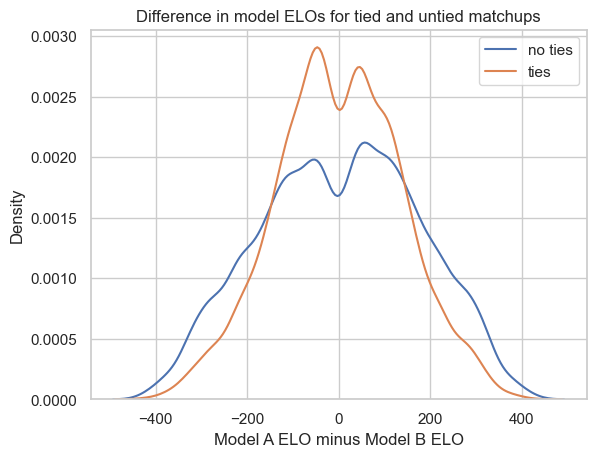

In [179]:
sns.kdeplot(df_train[~df_train['winner'].str.contains('tie')]['model_a_elo'] - df_train[~df_train['winner'].str.contains('tie')]['model_b_elo'], label='no ties')
sns.kdeplot(df_train[df_train['winner'].str.contains('tie')]['model_a_elo'] - df_train[df_train['winner'].str.contains('tie')]['model_b_elo'], label='ties')
plt.legend()
plt.xlabel('Model A ELO minus Model B ELO')
plt.title('Difference in model ELOs for tied and untied matchups')
plt.show()